In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Prepare Data 

In [2]:
from torch.utils.data import Subset
import numpy as np

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

def sample_dataset(dataset, num_samples_per_class=600, random_state=42):
    np.random.seed(random_state)  # Set the random state for reproducibility
    targets = np.array(dataset.targets)
    indices = []

    for class_label in range(10):  # MNIST has 10 classes
        class_indices = np.where(targets == class_label)[0]
        sampled_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)
        indices.extend(sampled_indices)

    sampled_dataset = Subset(dataset, indices)
    return sampled_dataset

# Apply the sampling function to both the train and test datasets with a specified random state
trainset_sampled = sample_dataset(trainset, random_state=42)
testset_sampled = sample_dataset(testset, random_state=42)

# Then create DataLoaders for the sampled datasets
trainloader_sampled = DataLoader(trainset_sampled, batch_size=64, shuffle=True)
testloader_sampled = DataLoader(testset_sampled, batch_size=64, shuffle=False)

trainloader_sampled

9913344it [00:01, 9496968.13it/s]                              


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


29696it [00:00, 9106825.44it/s]          


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




1649664it [00:00, 13356096.00it/s]                             

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



5120it [00:00, 11012736.66it/s]         

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



print(trainloader_sampled)

In [3]:
trainloader_sampled

# Draw -- Helper func

In [7]:
def draw(num_epochs, train_losses, test_losses, train_accuracies, test_accuracies):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def calculate_accuracy(y_pred, y_true):
    predicted = torch.argmax(y_pred, dim=1)
    correct = (predicted == y_true).float().sum()
    accuracy = correct / y_true.shape[0]
    return accuracy.item()


# CNN Implementation

Epoch 1, Train Loss: 0.5895, Train Accuracy: 0.8022, Test Loss: 0.9552, Test Accuracy: 0.7615
Epoch 2, Train Loss: 0.1151, Train Accuracy: 0.9638, Test Loss: 0.1030, Test Accuracy: 0.9695
Epoch 3, Train Loss: 0.0737, Train Accuracy: 0.9773, Test Loss: 0.0941, Test Accuracy: 0.9710
Epoch 4, Train Loss: 0.0321, Train Accuracy: 0.9908, Test Loss: 0.0550, Test Accuracy: 0.9828
Epoch 5, Train Loss: 0.0275, Train Accuracy: 0.9910, Test Loss: 0.1003, Test Accuracy: 0.9748
Epoch 6, Train Loss: 0.0336, Train Accuracy: 0.9897, Test Loss: 0.0546, Test Accuracy: 0.9867
Epoch 7, Train Loss: 0.0262, Train Accuracy: 0.9910, Test Loss: 0.0796, Test Accuracy: 0.9785
Epoch 8, Train Loss: 0.0124, Train Accuracy: 0.9960, Test Loss: 0.0689, Test Accuracy: 0.9855
Epoch 9, Train Loss: 0.0039, Train Accuracy: 0.9990, Test Loss: 0.0701, Test Accuracy: 0.9828
Epoch 10, Train Loss: 0.0014, Train Accuracy: 0.9997, Test Loss: 0.0489, Test Accuracy: 0.9868
Epoch 11, Train Loss: 0.0072, Train Accuracy: 0.9975, Test 

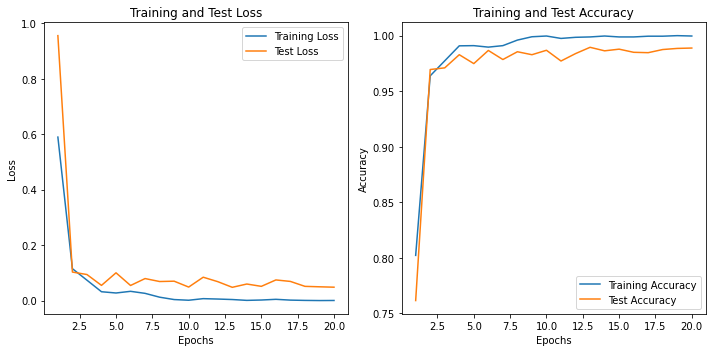

In [9]:
# CNN 
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            # 1
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # MNIST is grayscale, so 1 input channel
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # 4
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # 6
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 7
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # 8
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            # Define the fully connected layers
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)  # Output layer for 10 classes
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.classifier(x)
        return x

model = VGG11()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# train
def cnn_train(num_iter=100, train=trainloader_sampled):
    for epoch in range(num_iter):  # Loop over the dataset multiple times
        running_loss = 0.0
        tr_er, tr_lo, ts_er, ts_lo = [], [], [], []
        for i, data in enumerate(train, 0):
            inputs, labels = data
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()
            if i % 100 == 99:  # Print average loss every 100 mini-batches
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

    print('Finished Training')

#cnn_train()


def cnn_tr(num_epochs = 20):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in trainloader_sampled:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            correct_train += (torch.argmax(outputs, dim=1) == labels).float().sum()
            total_train += labels.size(0)
        
        train_loss = running_loss / len(trainloader_sampled)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy.item())
        
        model.eval()
        running_loss = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in testloader_sampled:
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                correct_test += (torch.argmax(outputs, dim=1) == labels).float().sum()
                total_test += labels.size(0)
                
        test_loss = running_loss / len(testloader_sampled)
        test_accuracy = correct_test / total_test
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy.item())
        
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    return num_epochs, train_losses, test_losses, train_accuracies, test_accuracies
    
num_epochs, train_losses, test_losses, train_accuracies, test_accuracies = cnn_tr()
draw(num_epochs, train_losses, test_losses, train_accuracies, test_accuracies)

# 3. Train w Adam

Epoch 1, Train Loss: 10.2912, Train Accuracy: 0.1120, Test Loss: 2.3047, Test Accuracy: 0.1000
Epoch 2, Train Loss: 2.3147, Train Accuracy: 0.1260, Test Loss: 2.1950, Test Accuracy: 0.1642
Epoch 3, Train Loss: 2.2527, Train Accuracy: 0.1658, Test Loss: 2.1283, Test Accuracy: 0.1578
Epoch 4, Train Loss: 2.2218, Train Accuracy: 0.1548, Test Loss: 2.2189, Test Accuracy: 0.1950
Epoch 5, Train Loss: 2.2107, Train Accuracy: 0.1655, Test Loss: 2.3149, Test Accuracy: 0.1072
Epoch 6, Train Loss: 2.2767, Train Accuracy: 0.1547, Test Loss: 6.2869, Test Accuracy: 0.1710
Epoch 7, Train Loss: 2.3760, Train Accuracy: 0.1193, Test Loss: 2.2822, Test Accuracy: 0.0588
Epoch 8, Train Loss: 2.2786, Train Accuracy: 0.1252, Test Loss: 2.2621, Test Accuracy: 0.1857
Epoch 9, Train Loss: 2.2544, Train Accuracy: 0.1403, Test Loss: 2.1398, Test Accuracy: 0.1952
Epoch 10, Train Loss: 2.1633, Train Accuracy: 0.1682, Test Loss: 1.9076, Test Accuracy: 0.2017
Epoch 11, Train Loss: 1.9558, Train Accuracy: 0.1953, Test

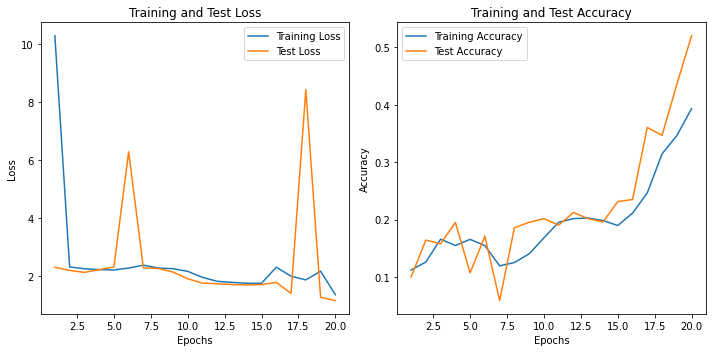

In [12]:
model = VGG11()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs, train_losses, test_losses, train_accuracies, test_accuracies = cnn_tr(20)
draw(num_epochs, train_losses, test_losses, train_accuracies, test_accuracies)

# 4. Replace ReLU activation with Sigmoid 

Epoch 1, Train Loss: 2.6539, Train Accuracy: 0.0992, Test Loss: 2.4305, Test Accuracy: 0.1000
Epoch 2, Train Loss: 2.4714, Train Accuracy: 0.1062, Test Loss: 2.4366, Test Accuracy: 0.1000
Epoch 3, Train Loss: 2.3034, Train Accuracy: 0.1382, Test Loss: 2.1063, Test Accuracy: 0.1895
Epoch 4, Train Loss: 1.9702, Train Accuracy: 0.2100, Test Loss: 1.7307, Test Accuracy: 0.2753
Epoch 5, Train Loss: 1.7277, Train Accuracy: 0.2748, Test Loss: 1.5915, Test Accuracy: 0.4817
Epoch 6, Train Loss: 1.4921, Train Accuracy: 0.3992, Test Loss: 3.2882, Test Accuracy: 0.1028
Epoch 7, Train Loss: 1.2160, Train Accuracy: 0.5302, Test Loss: 1.1410, Test Accuracy: 0.5862
Epoch 8, Train Loss: 0.9253, Train Accuracy: 0.6568, Test Loss: 0.7085, Test Accuracy: 0.7530
Epoch 9, Train Loss: 0.6343, Train Accuracy: 0.7743, Test Loss: 0.6490, Test Accuracy: 0.7782
Epoch 10, Train Loss: 0.4315, Train Accuracy: 0.8662, Test Loss: 1.3042, Test Accuracy: 0.5463
Epoch 11, Train Loss: 0.3416, Train Accuracy: 0.8967, Test 

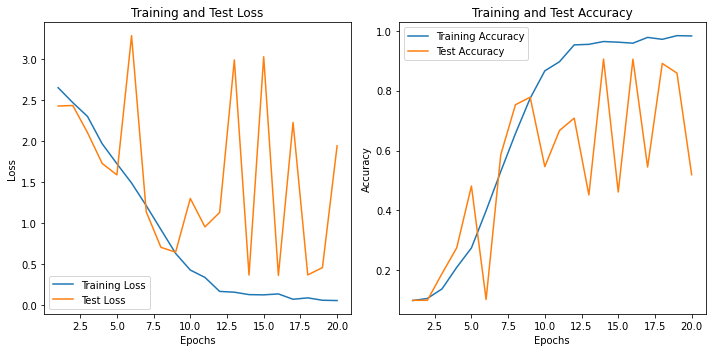

In [14]:
# CNN 
class VGG11_sgm(nn.Module):
    def __init__(self):
        super(VGG11_sgm, self).__init__()
        self.features = nn.Sequential(
            # 1
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # MNIST is grayscale, so 1 input channel
            nn.BatchNorm2d(64),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  
            nn.BatchNorm2d(128),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  
            nn.BatchNorm2d(256),
            nn.Sigmoid(),
            # 4
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  
            nn.BatchNorm2d(256),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            # 6
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 7
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            # 8
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            # Define the fully connected layers
            nn.Linear(512, 4096),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)  # Output layer for 10 classes
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.classifier(x)
        return x

model = VGG11_sgm()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# train
def cnn_tr(num_epochs = 20):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in trainloader_sampled:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            correct_train += (torch.argmax(outputs, dim=1) == labels).float().sum()
            total_train += labels.size(0)
        
        train_loss = running_loss / len(trainloader_sampled)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy.item())
        
        model.eval()
        running_loss = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in testloader_sampled:
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                correct_test += (torch.argmax(outputs, dim=1) == labels).float().sum()
                total_test += labels.size(0)
                
        test_loss = running_loss / len(testloader_sampled)
        test_accuracy = correct_test / total_test
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy.item())
        
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    return num_epochs, train_losses, test_losses, train_accuracies, test_accuracies
    
num_epochs, train_losses, test_losses, train_accuracies, test_accuracies = cnn_tr()
draw(num_epochs, train_losses, test_losses, train_accuracies, test_accuracies)